# 07_Poincare_Coor_vs_feature_corr

Correlate PCs/dimensions and specific markers with distance from origin

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/cchu/Desktop/phd_work/hyperChromatin/src/PoincareMaps')
import os
workdir = '../results/07'
os.makedirs(workdir, exist_ok=True)


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import torch 
from refs import celltype_colors
import matplotlib.pyplot as plt
from IPython.display import Image
from run_poincare_map import features_names

from main import *
from poincare_maps import *

features_names

{'RNA PCA': '../results/02/rna_pca.celltype_label',
 'RNA Simba': '../results/02/rna_simba.celltype_label',
 'ATAC PCA': '../results/02/atac_pca.celltype_label',
 'ATAC PCA (standard)': '../results/02/atac_std_pca.celltype_label',
 'ATAC Simba': '../results/02/atac_simba.celltype_label',
 'Simba Multi': '../results/02/multi_simba.celltype_label'}

In [4]:
adata_CG_fn = '../results/00/rna_annot.h5ad'
adata_CP_fn = '../results/00/atac_annot.h5ad'
adata_CP_std_fn = '../results/00/atac_std_annot.h5ad'

adata_CG = sc.read_h5ad(adata_CG_fn)
adata_CP = sc.read_h5ad(adata_CP_fn)
adata_CP_std = sc.read_h5ad(adata_CP_std_fn)

In [3]:
rna_pca_name = '../results/03/rna_pca.celltype_label'
rna_simba_name = '../results/03/rna_simba.celltype_label'
atac_pca_name = '../results/03/atac_std_pca.celltype_label'
atac_simba_name = '../results/03/atac_simba.celltype_label'
simba_multi_name = '../results/03/multi_simba.celltype_label'

names = [rna_pca_name, rna_simba_name, atac_pca_name, atac_simba_name, simba_multi_name]

poincare_results = {
    "RNA PCA": rna_pca_name, "RNA Simba": rna_simba_name, 
    "ATAC PCA (standard)": atac_pca_name, "ATAC Simba": atac_simba_name, 
    "Simba Multi": simba_multi_name
}

In [7]:
dist_from_origins_fn = "../results/05/dist_from_origins.csv"
dist_from_origins_df = pd.read_csv(dist_from_origins_fn, sep=',')

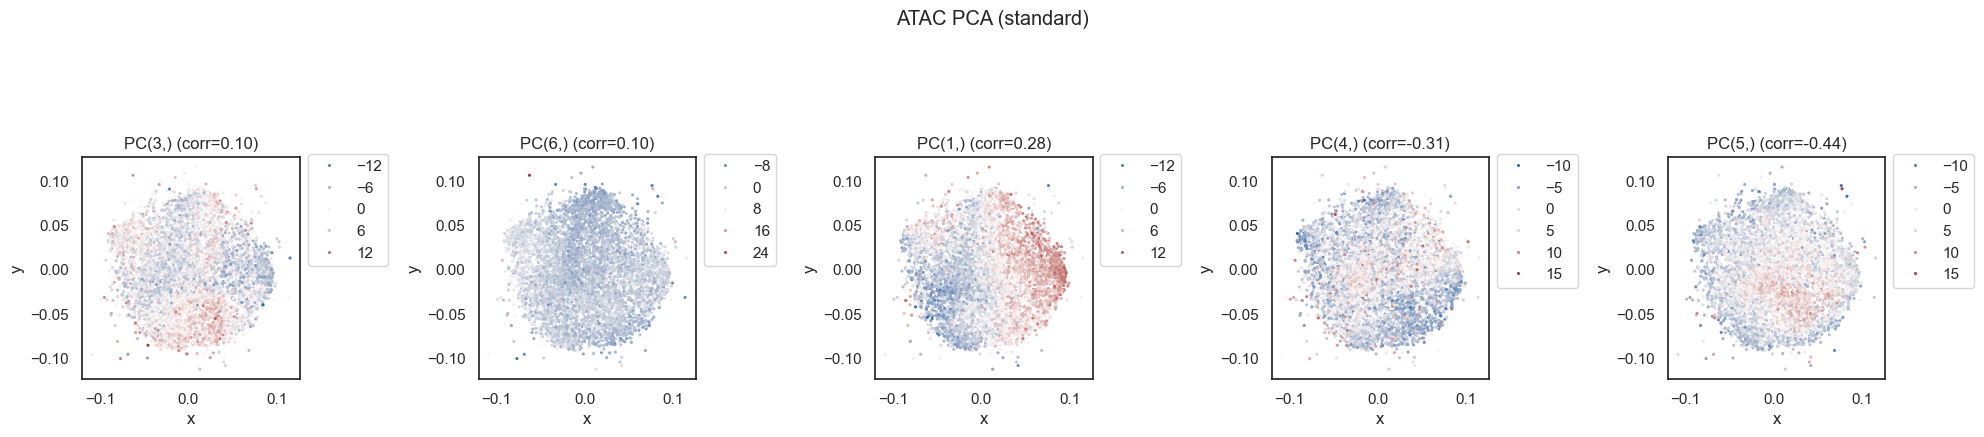

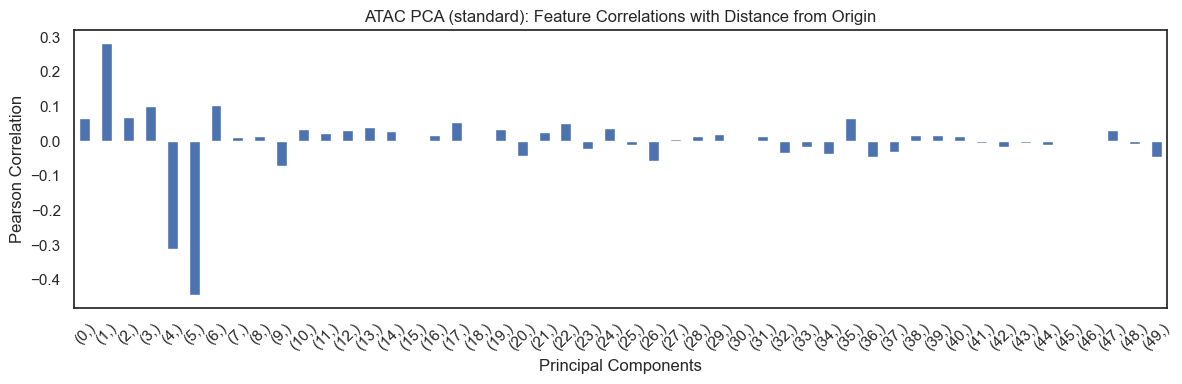

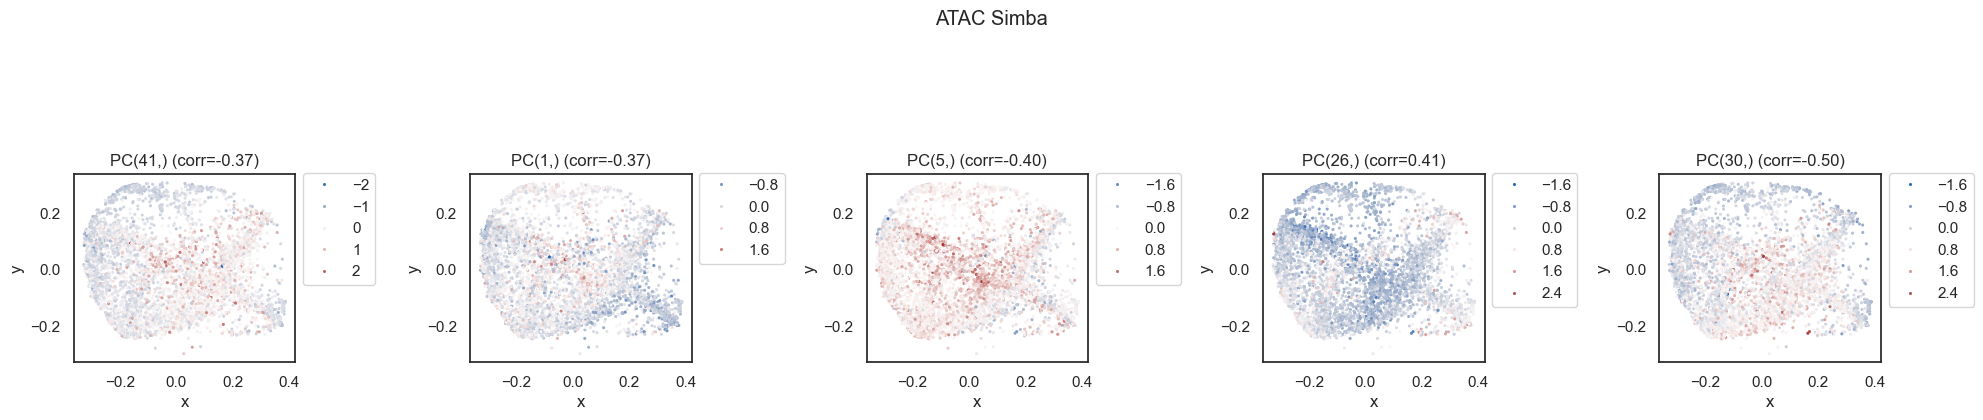

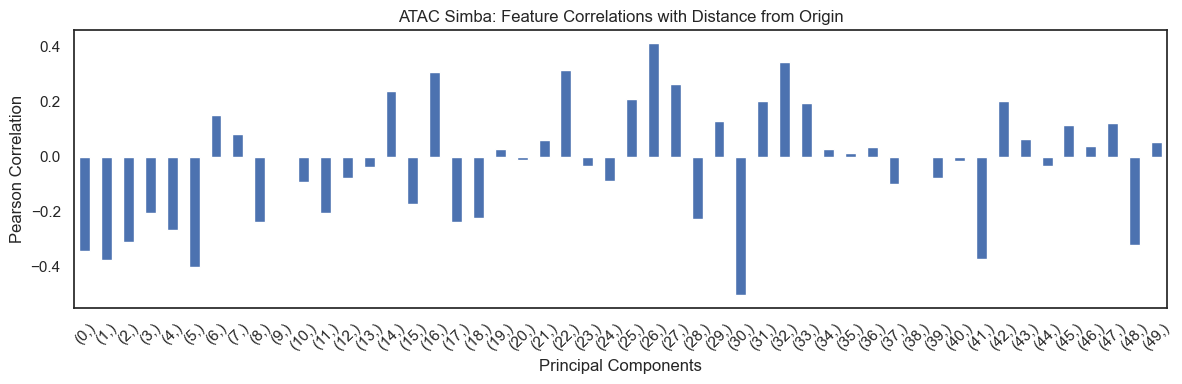

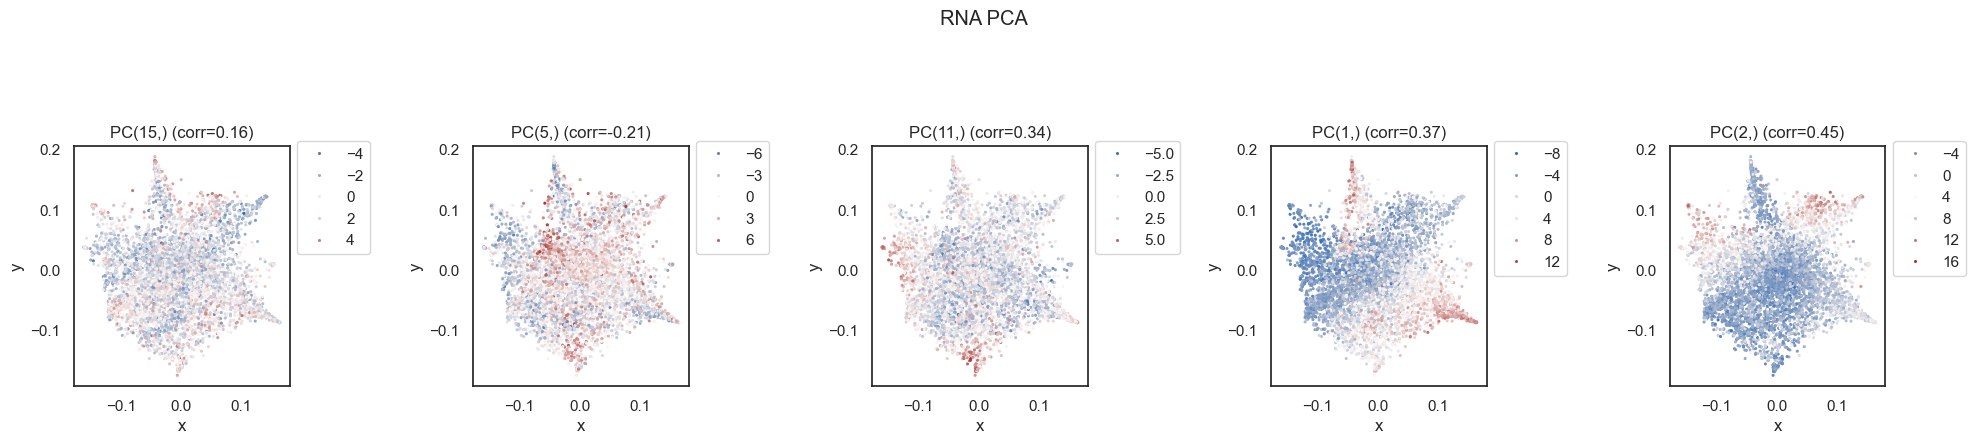

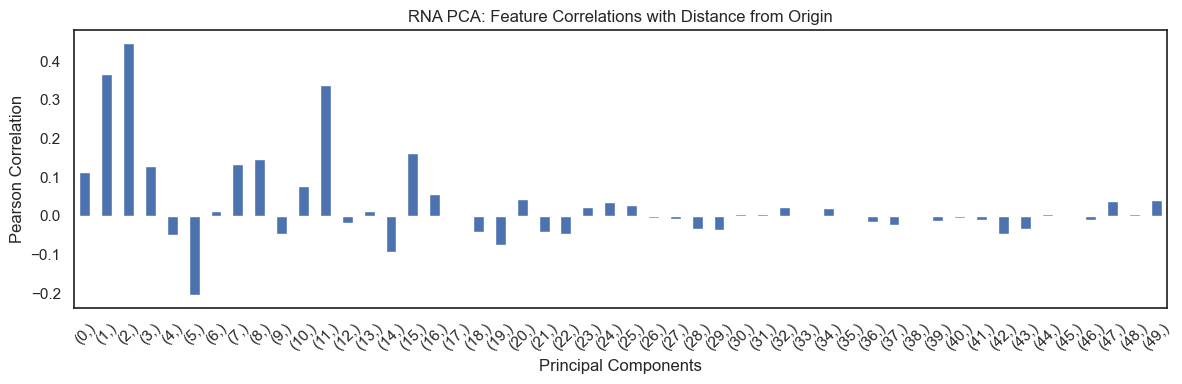

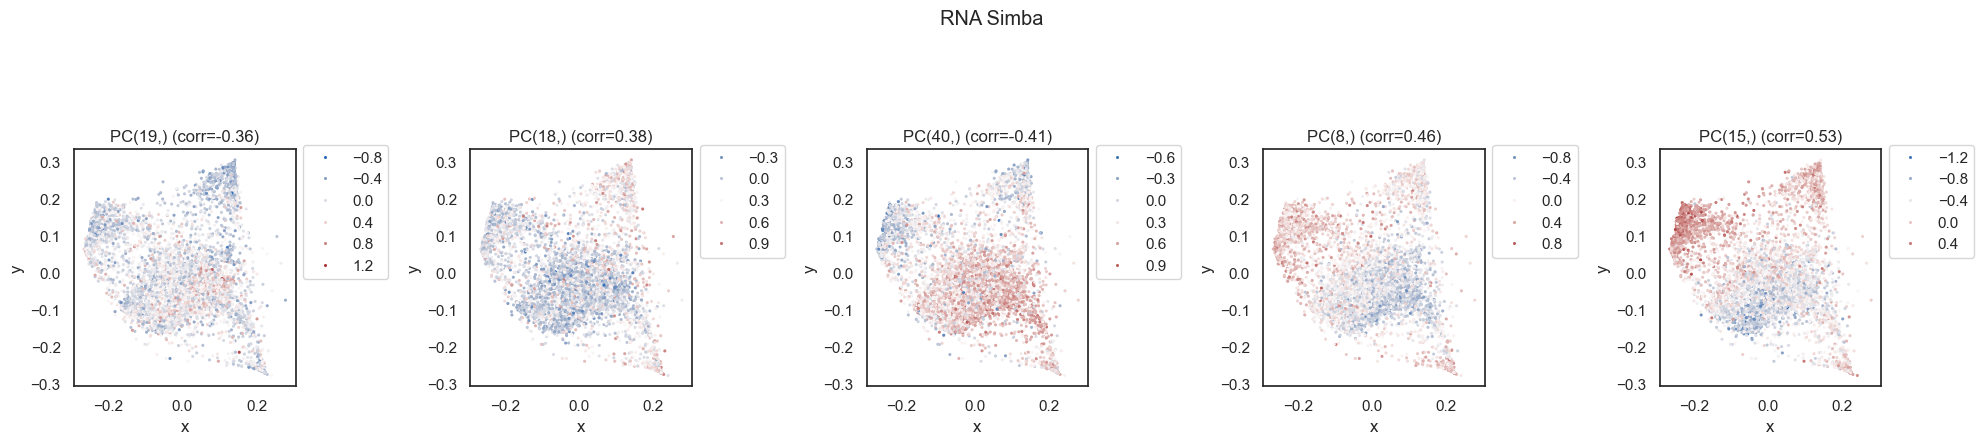

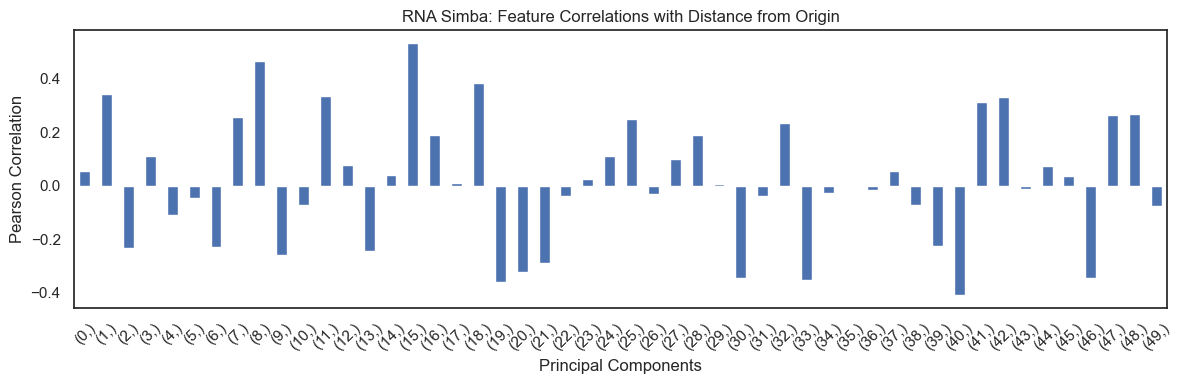

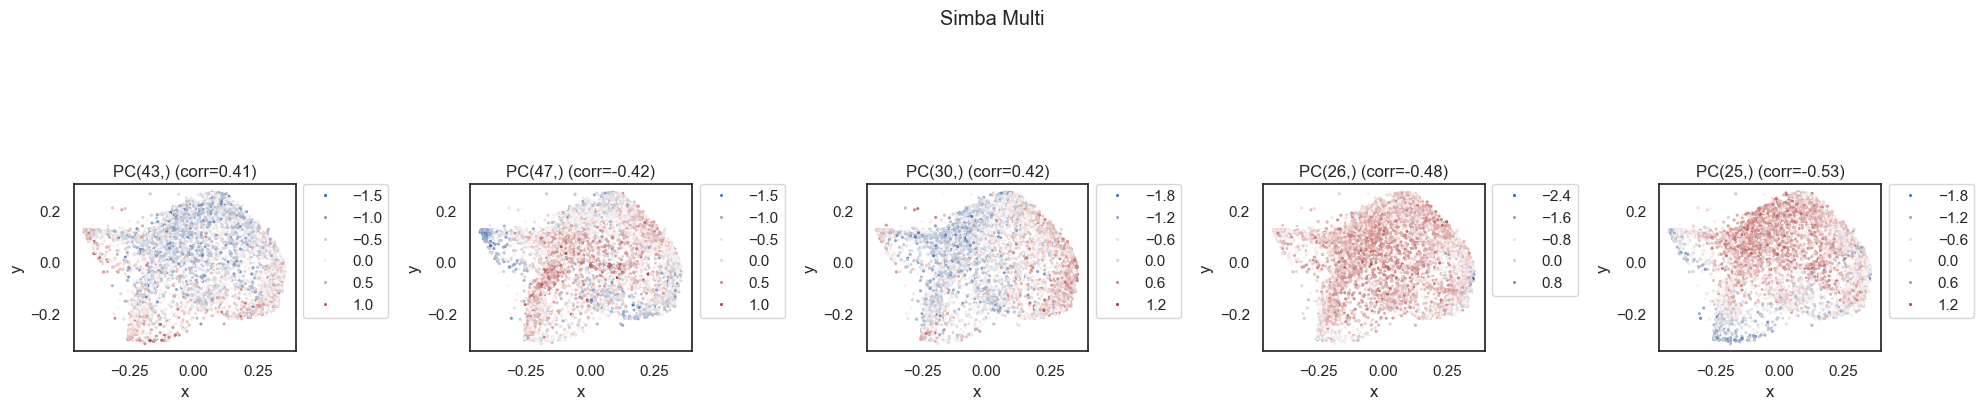

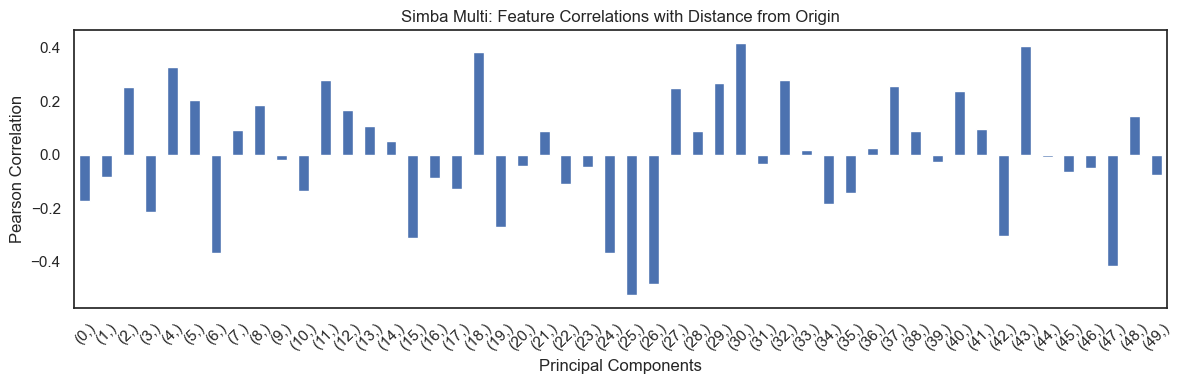

In [74]:
all_correlations = {}
for name, df in dist_from_origins_df.groupby("name"):
    features_df = pd.read_csv(f"{features_names[name]}.csv", sep=',').drop(columns='labels')
    correlations = []
    for col in features_df.columns.tolist():
        corr = np.corrcoef(features_df[col].values, df['dist_from_origin'])[0,1]
        correlations.append(corr)

    # Convert to pandas Series for easier visualization
    correlations = pd.Series(correlations, name='correlation')
    correlations.index = [features_df.columns.astype(int).tolist()]
    all_correlations[name] = correlations

    # plot
    top_corr_pcs = np.abs(correlations).sort_values().tail()
    fig, axes = plt.subplots(1, top_corr_pcs.shape[0], figsize=(20, 5))
    for i, (pc_col, corr) in enumerate(top_corr_pcs.items()):
        sns.scatterplot(df, x='x', y='y', hue=features_df[str(pc_col[0])].values, palette="vlag", ax=axes[i], linewidth=0, s=5)
        axes[i].set_title(f"PC{pc_col} (corr={correlations.loc[pc_col]:.2f})")
        axes[i].set_aspect('equal')
        axes[i].legend(bbox_to_anchor=(1, 1.05))
    fig.suptitle(name)
    plt.tight_layout()
    plt.show()

    # Optional: visualize the correlations
    plt.figure(figsize=(12, 4))
    correlations.plot(kind='bar')
    plt.title(f'{name}: Feature Correlations with Distance from Origin')
    plt.xlabel('Principal Components')
    plt.ylabel('Pearson Correlation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    


# minimum spanning tree

In [75]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree

from networkx import from_scipy_sparse_array

In [92]:
features_names

{'RNA PCA': '../results/02/rna_pca.celltype_label',
 'RNA Simba': '../results/02/rna_simba.celltype_label',
 'ATAC PCA': '../results/02/atac_pca.celltype_label',
 'ATAC PCA (standard)': '../results/02/atac_std_pca.celltype_label',
 'ATAC Simba': '../results/02/atac_simba.celltype_label',
 'Simba Multi': '../results/02/multi_simba.celltype_label'}

In [170]:
x_coords

[0.088504486, 0.090822615]

In [238]:
from scipy.stats import skew

In [ ]:
dist_from_origins_df['name'].unique()

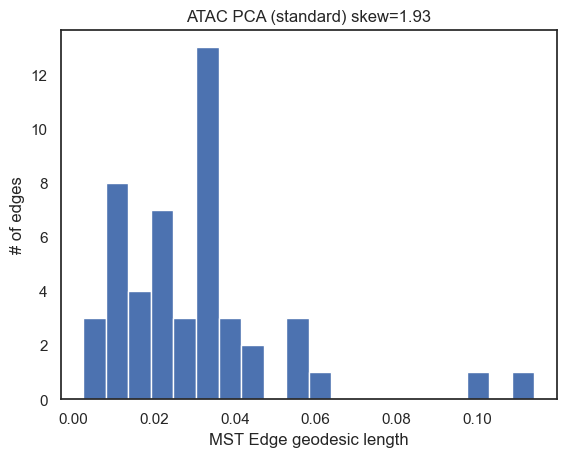

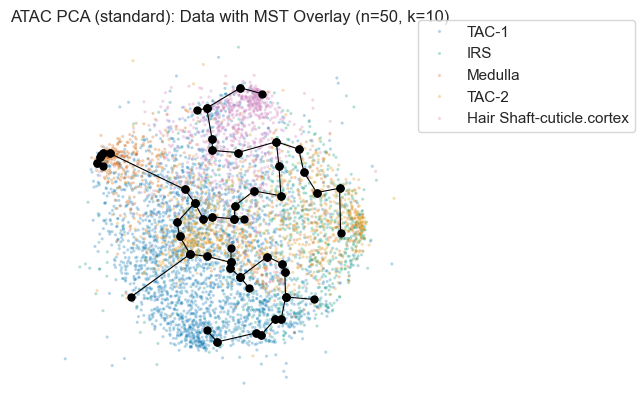

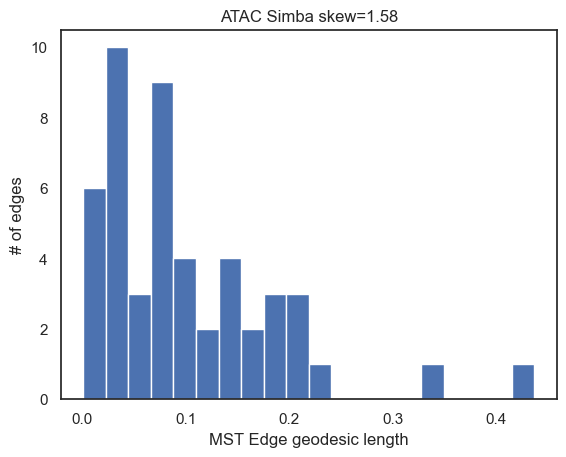

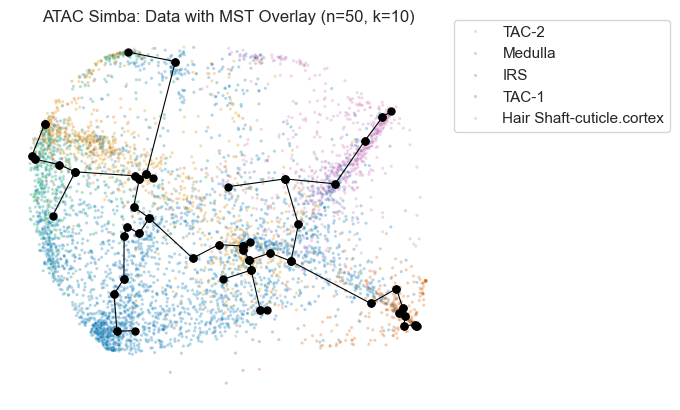

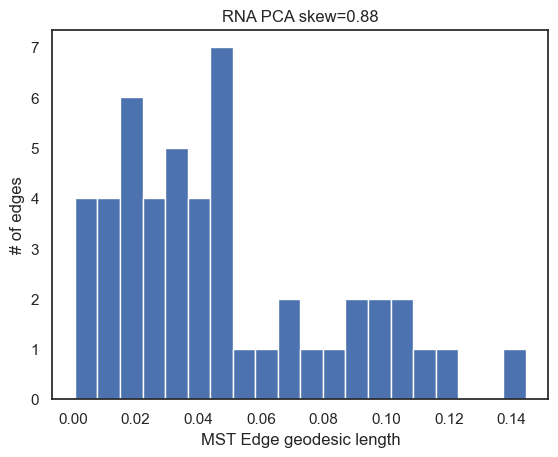

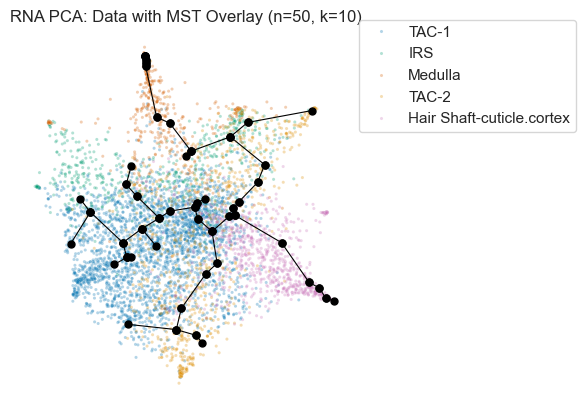

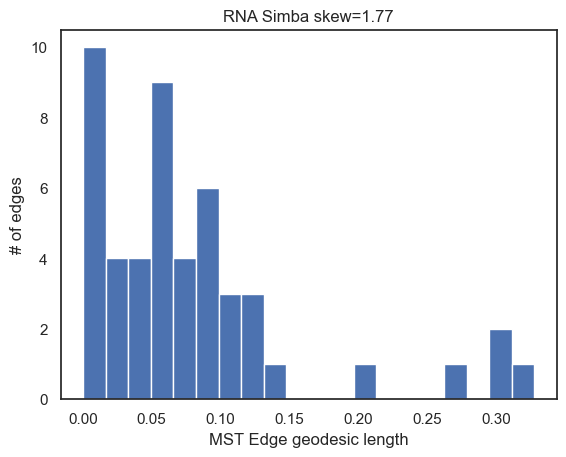

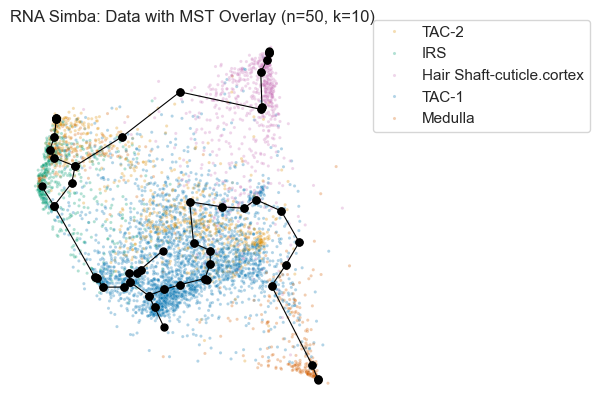

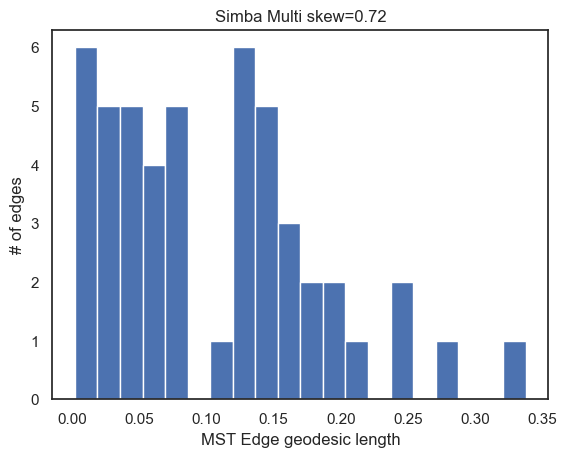

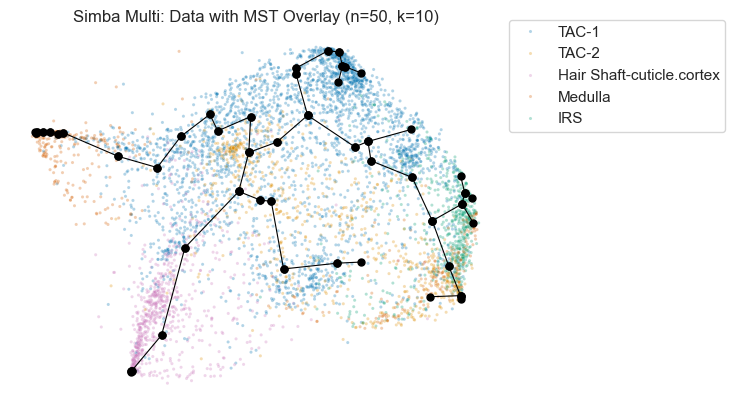

In [309]:
branchiness_results = {}
branchlength_skewness = {name: [] for name in dist_from_origins_df['name'].unique()}
var_results = {name: [] for name in dist_from_origins_df['name'].unique()}
sample_size = 50
k = 10  # you can adjust this

num_samplings = 100
for feature_name, df in dist_from_origins_df.groupby('name'):
    features_df = pd.read_csv(f"{features_names[feature_name]}.csv", sep=',').drop(columns='labels')

    for i in range(num_samplings):

        sample_idx = np.random.choice(np.arange(df.shape[0]), size=sample_size, replace=False)
        X = df.iloc[sample_idx][['x', 'y']].values
        # Assume X is your N x D data matrix
        
        nbrs = NearestNeighbors(n_neighbors=k, metric=lambda x, y: poin_dist(torch.tensor(x), torch.tensor(y)), algorithm='brute').fit(X)
        # nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
        distances, indices = nbrs.kneighbors(X)

        # Construct sparse adjacency matrix
        N = X.shape[0]
        row_indices = np.repeat(np.arange(N), k)
        col_indices = indices.flatten()
        edge_weights = distances.flatten()

        # make MST
        knn_graph = csr_matrix((edge_weights, (row_indices, col_indices)), shape=(N, N))
        # Make it symmetric (undirected)
        knn_graph = knn_graph.maximum(knn_graph.T)

        mst_sparse = minimum_spanning_tree(knn_graph)
        G_mst = from_scipy_sparse_array(mst_sparse)

        mst_edge_lengths = []
        for u, v in G_mst.edges():
            # Calculate Poincaré distance between points u and v
            point_u = torch.tensor(X[u])
            point_v = torch.tensor(X[v])
            edge_length = poin_dist(point_u, point_v)
            mst_edge_lengths.append(edge_length)

        skewness = skew(mst_edge_lengths)
        diff_median_and_max = np.max(mst_edge_lengths) - np.median(mst_edge_lengths)
        var = np.var(mst_edge_lengths)

        branchlength_skewness[feature_name].append(skewness)
        var_results[feature_name].append(var)
        # diff_median_and_max_results[name].append(diff_median_and_max)


    plt.hist(mst_edge_lengths, bins=20) # skip self
    plt.xlabel('MST Edge geodesic length')
    plt.ylabel('# of edges')
    plt.title(f'{feature_name} skew={skewness:.2f}')
    plt.show()

    

    # # Optionally analyze node degrees
    # degree_dict = dict(G_mst.degree())
    # branch_nodes = [n for n, d in degree_dict.items() if d >= 3]
    # branchiness = len(branch_nodes) / len(G_mst.nodes)
    # branchiness_results[feature_name] = branchiness

    # Plot points
    fig, ax = plt.subplots()
    zoom1_coordinates = np.array(linear_scale(df[['x', 'y']].values))
    zoom_df = df.copy()
    zoom_df[['x', 'y']] = zoom1_coordinates
    sns.scatterplot(df, x='x', y='y', s=5, alpha=0.3, color='lightgray', hue='labels', palette=celltype_colors, ax=ax)

    # Overlay MST edges
    for u, v in G_mst.edges():
        x_coords = [X[u, 0], X[v, 0]]
        y_coords = [X[u, 1], X[v, 1]]

        # zoom1_coordinates = np.array(linear_scale(np.array([x_coords, y_coords]).T))
        plt.plot(x_coords, y_coords, color='black', linewidth=0.8, marker='o', markersize=5)

    plt.title(f"{feature_name}: Data with MST Overlay (n={sample_size}, k={k})")
    plt.axis('off')
    ax.set_aspect('equal')
    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.show()


In [310]:
branchlength_skewness_df = pd.DataFrame(branchlength_skewness).stack().reset_index().rename(columns={'level_1': 'method', 0: 'Branch length skewness'})
var_results_df = pd.DataFrame(var_results).stack().reset_index().rename(columns={'level_1': 'method', 0: 'var'})
display(var_results_df.head())
branchlength_skewness_df.head()

level_0               method       var
0        0              RNA PCA  0.000994
1        0            RNA Simba  0.004668
2        0  ATAC PCA (standard)  0.000339
3        0           ATAC Simba  0.005621
4        0          Simba Multi  0.009018

level_0               method  Branch length skewness
0        0              RNA PCA                0.561728
1        0            RNA Simba                1.553722
2        0  ATAC PCA (standard)                1.283465
3        0           ATAC Simba                0.865230
4        0          Simba Multi                1.934813

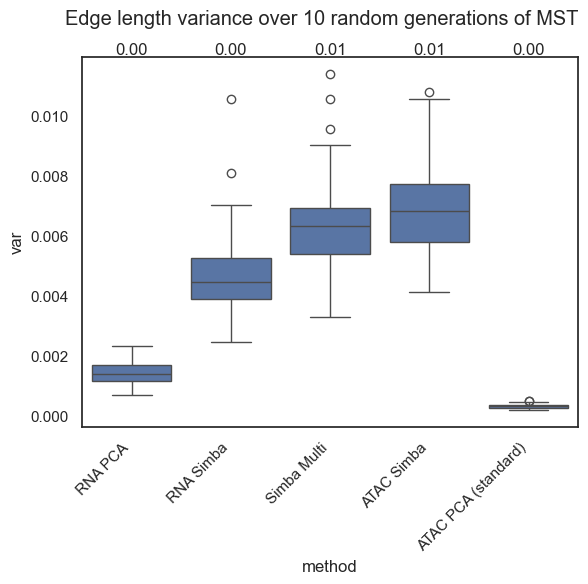

In [311]:
ax = sns.boxplot(
    var_results_df, x='method', y='var', 
    order=['RNA PCA', 'RNA Simba', 'Simba Multi', 'ATAC Simba', 'ATAC PCA (standard)'],
)

for i, method in enumerate(['RNA PCA', 'RNA Simba', 'Simba Multi', 'ATAC Simba', 'ATAC PCA (standard)']):
    median = var_results_df[var_results_df['method'] == method]['var'].median()
    ax.text(i, ax.get_ylim()[1], f'{median:.2f}', 
            horizontalalignment='center', verticalalignment='bottom')

plt.xticks(rotation=45, ha='right')
plt.suptitle("Edge length variance over 10 random generations of MST")
plt.show()

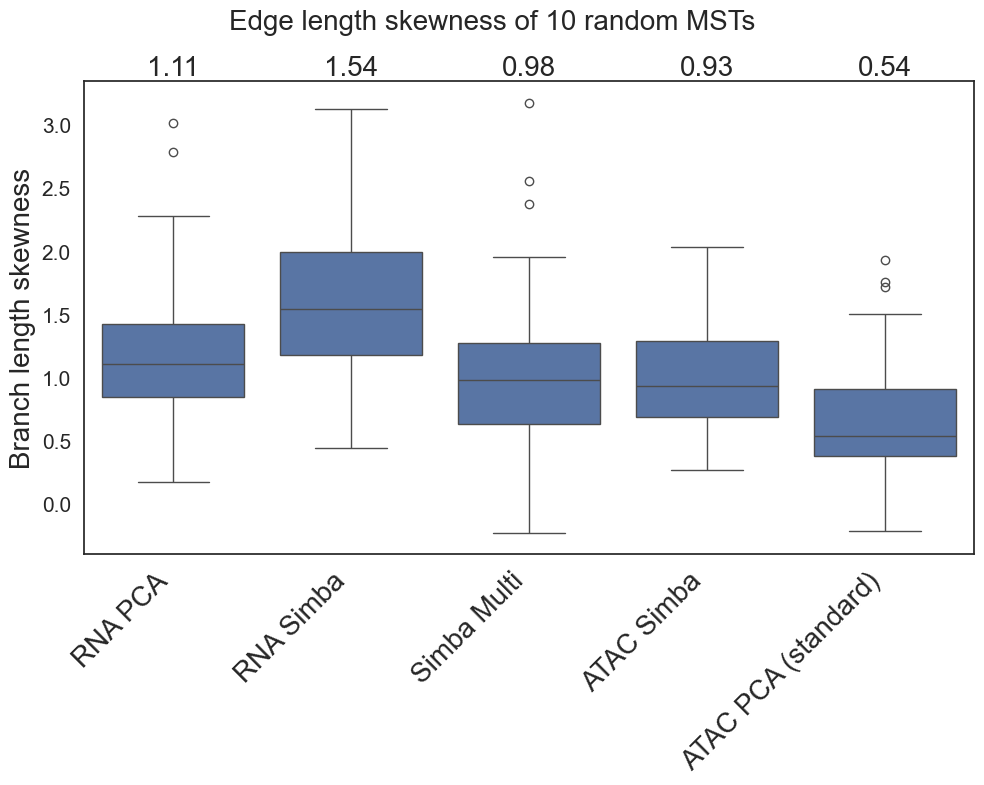

In [373]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(
    branchlength_skewness_df, x='method', y='Branch length skewness', 
    order=['RNA PCA', 'RNA Simba', 'Simba Multi', 'ATAC Simba', 'ATAC PCA (standard)'],
)

for i, method in enumerate(['RNA PCA', 'RNA Simba', 'Simba Multi', 'ATAC Simba', 'ATAC PCA (standard)']):
    median = branchlength_skewness_df[branchlength_skewness_df['method'] == method]['Branch length skewness'].median()
    ax.text(i, ax.get_ylim()[1], f'{median:.2f}', 
            horizontalalignment='center', verticalalignment='bottom', fontsize=20)

plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Branch length skewness', fontsize=20)
plt.suptitle("Edge length skewness of 10 random MSTs", fontsize=20)
plt.tight_layout()
plt.show()

More spread along radius vs concentration with angle?

In [229]:
dist_from_origins_df['origin_angle'] = dist_from_origins_df.apply(lambda r: np.arctan2(r.x, r.y), axis=1)

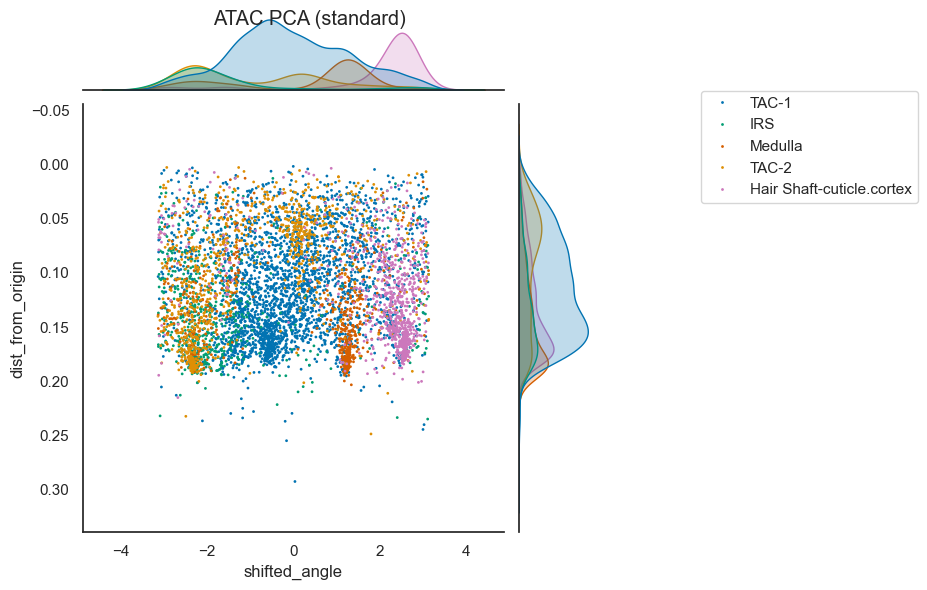

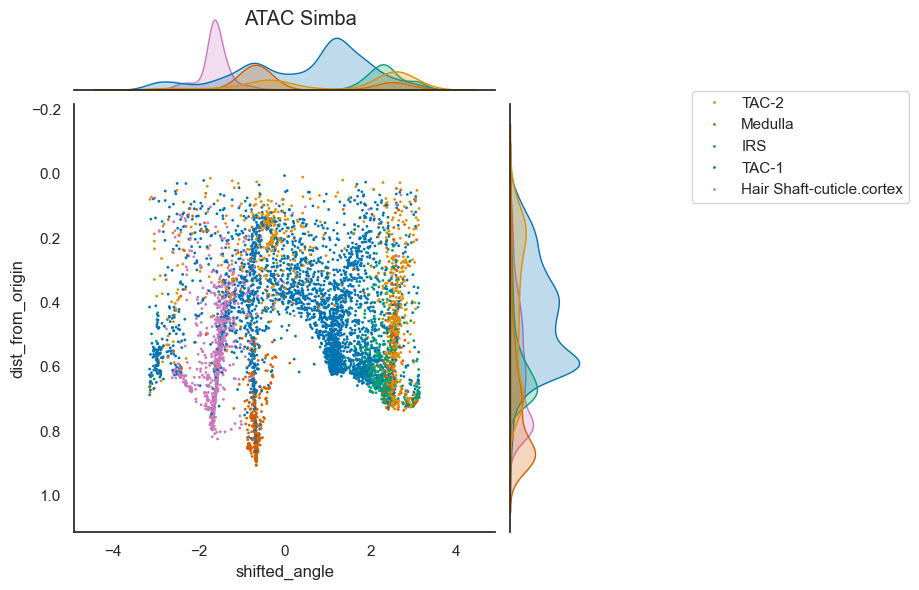

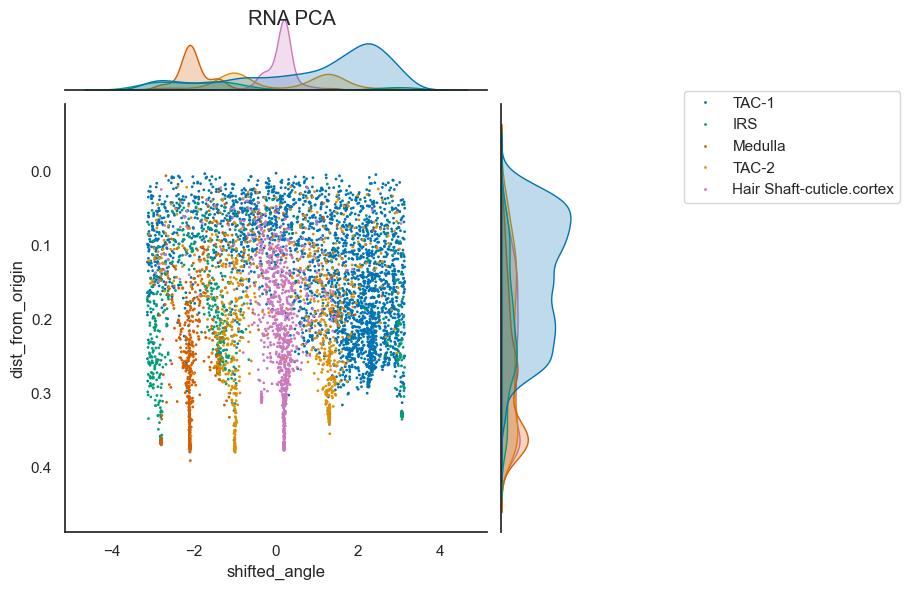

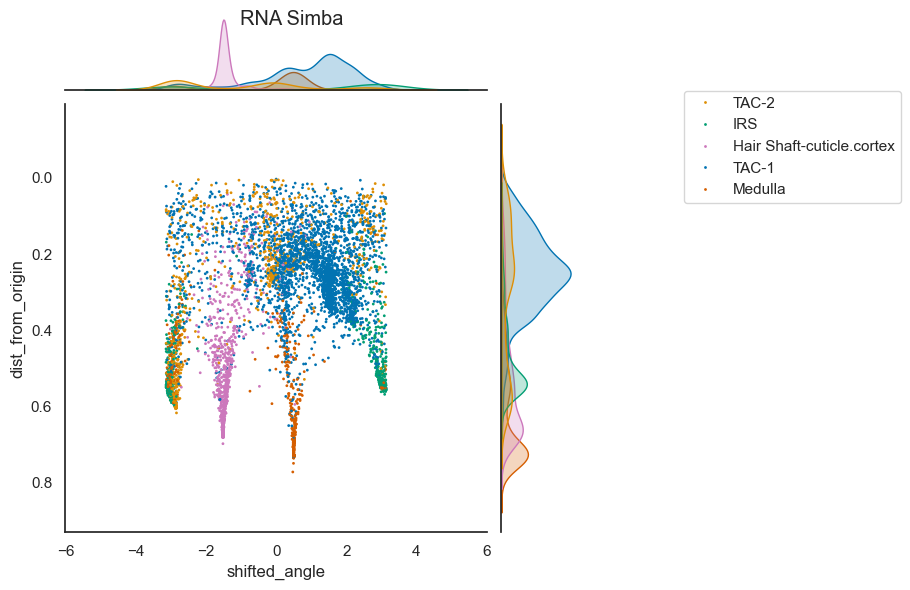

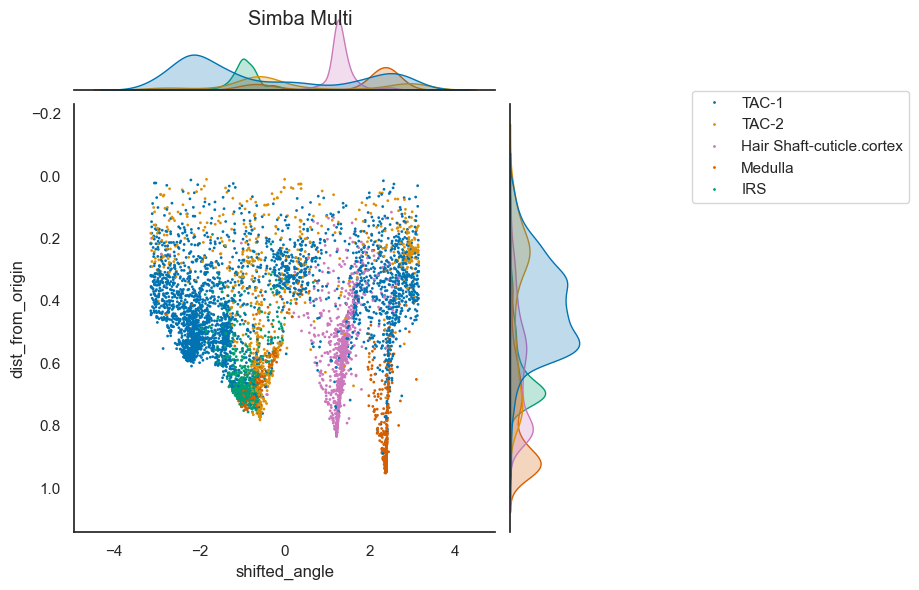

In [314]:
for name, df in dist_from_origins_df.groupby('name'):
    shift = df.sort_values(by=['dist_from_origin']).iloc[0]['angle']
    df['shifted_angle'] = (df['origin_angle'] - shift + np.pi) % (2 * np.pi) - np.pi

    sns.jointplot(df, x='shifted_angle', y='dist_from_origin', hue='labels', linewidth=0, s=4, palette=celltype_colors)
    plt.suptitle(name)
    plt.legend(bbox_to_anchor=(2, 1.05))
    plt.tight_layout()
    plt.gca().invert_yaxis()

    plt.show()

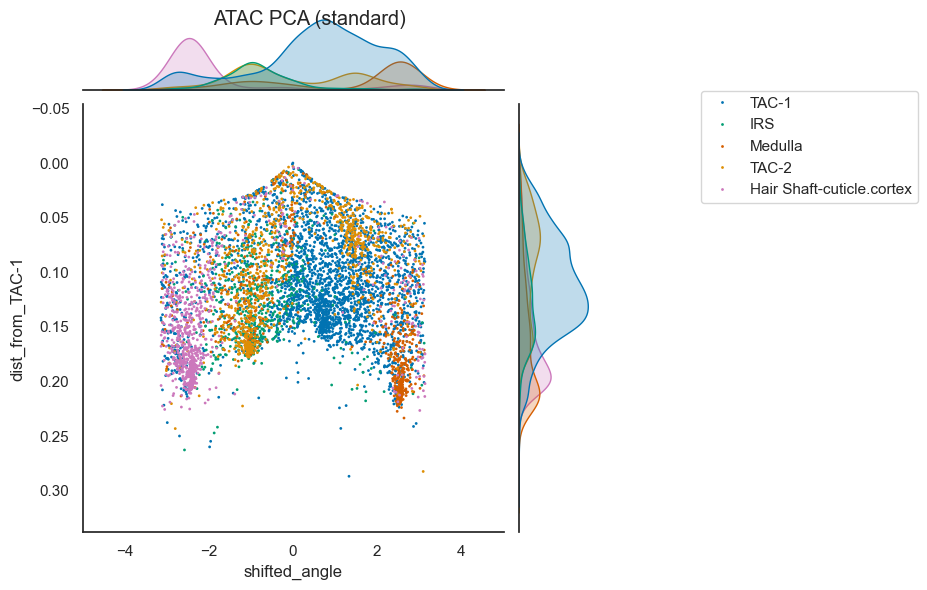

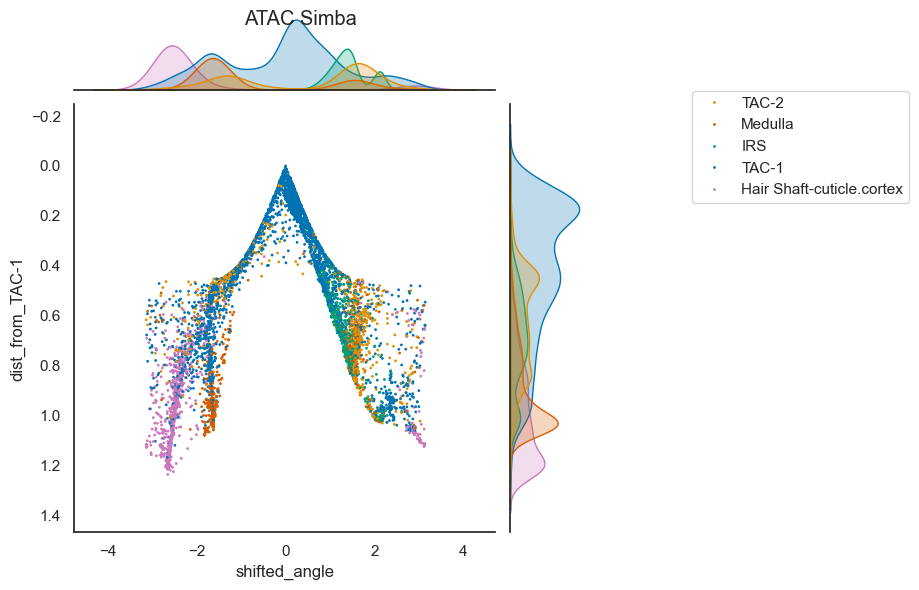

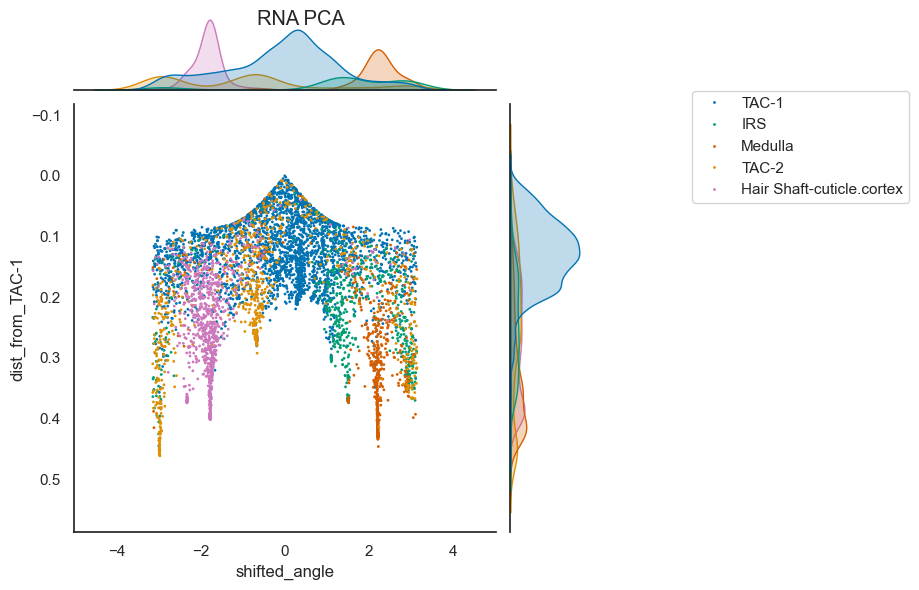

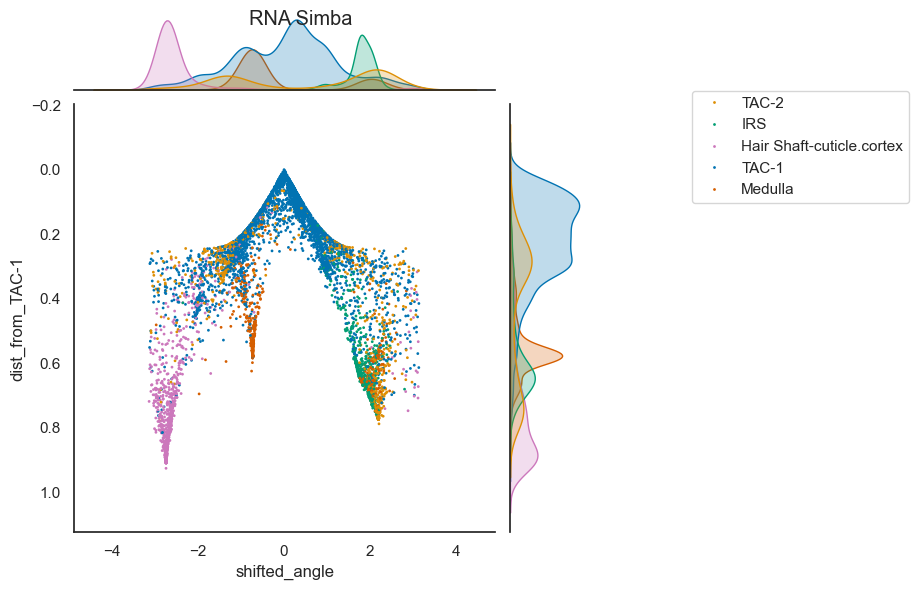

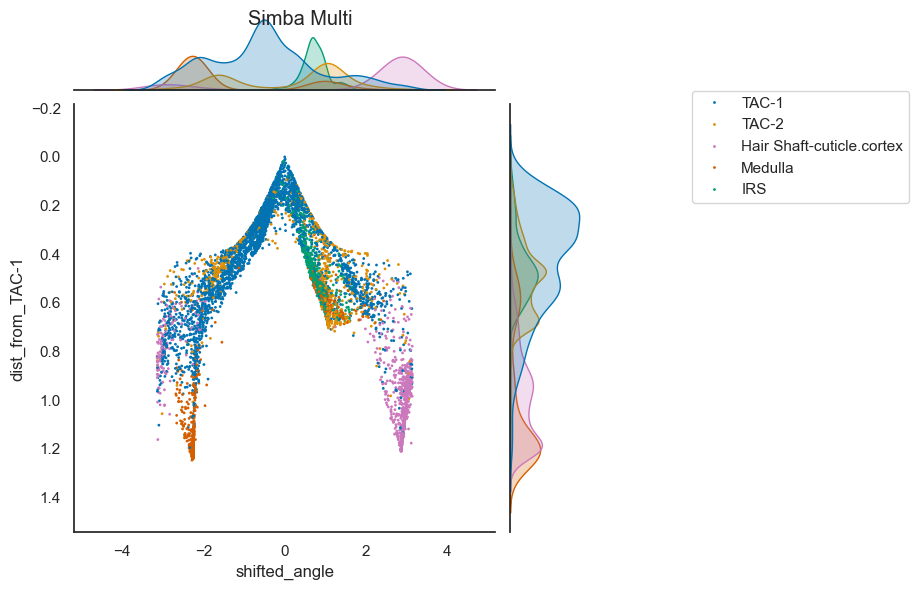

In [344]:
corr_result = {}
for name, df in dist_from_origins_df.groupby('name'):
    shift = df.sort_values(by=['dist_from_TAC-1']).iloc[0]['angle']
    df['shifted_angle'] = (df['origin_angle'] - shift + np.pi) % (2 * np.pi) - np.pi


    sns.jointplot(df, x='shifted_angle', y='dist_from_TAC-1', hue='labels', linewidth=0, s=4, palette=celltype_colors)
    plt.suptitle(f"{name}")
    plt.gca().invert_yaxis()

    plt.legend(bbox_to_anchor=(2, 1.05))
    plt.tight_layout()
    plt.show()

Text(0, 0.5, 'absolute angle vs distance from TAC-1 Pearson R')

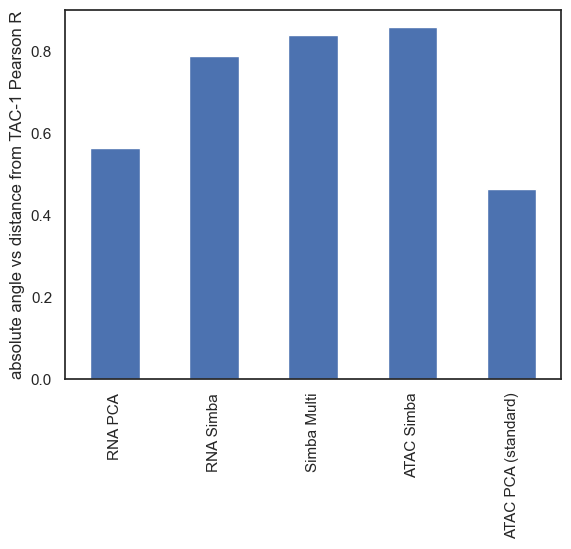

In [316]:
corr_result_s = pd.Series(corr_result).loc[['RNA PCA', 'RNA Simba', 'Simba Multi', 'ATAC Simba', 'ATAC PCA (standard)']]
corr_result_s.plot(kind='bar')
plt.ylabel("absolute angle vs distance from TAC-1 Pearson R")

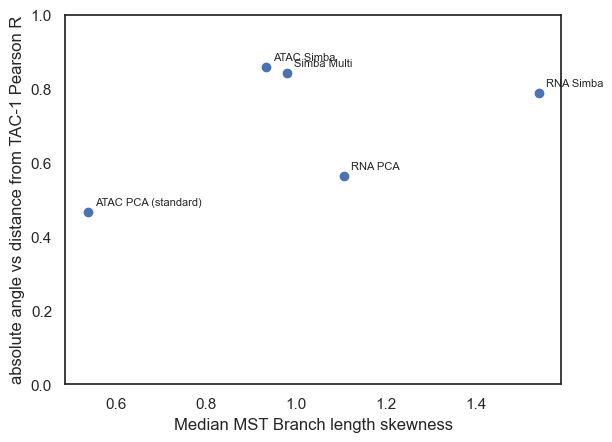

In [318]:
plt.scatter(
    x=branchlength_skewness_df.groupby('method')['Branch length skewness'].median().loc[corr_result_s.index], y=corr_result_s
)

for method in corr_result_s.index:
    x = branchlength_skewness_df.groupby('method')['Branch length skewness'].median()[method]
    y = corr_result_s[method]
    plt.annotate(
        method,
        (x, y),
        xytext=(5, 5),  # 5 points offset
        textcoords='offset points',
        fontsize=8,
        ha='left'  # horizontal alignment
    )
    
plt.xlabel("Median MST Branch length skewness")
plt.ylabel('absolute angle vs distance from TAC-1 Pearson R')
plt.ylim(0, 1)
plt.show()

In [319]:
from scipy.stats import entropy

In [339]:
angle_entropy = dist_from_origins_df.groupby("name").apply(lambda df: entropy(np.histogram(df['origin_angle'], bins=100)[0]))

In [340]:
dist_from_origin_entropy = dist_from_origins_df.groupby("name").apply(lambda df: entropy(np.histogram(df['dist_from_origin'], bins=100)[0]))

In [345]:
dist_from_TAC1_entropy = dist_from_origins_df.groupby("name").apply(lambda df: entropy(np.histogram(df['dist_from_TAC-1'], bins=100)[0]))

ATAC PCA (standard) right
ATAC Simba left
RNA PCA left
RNA Simba left
Simba Multi left


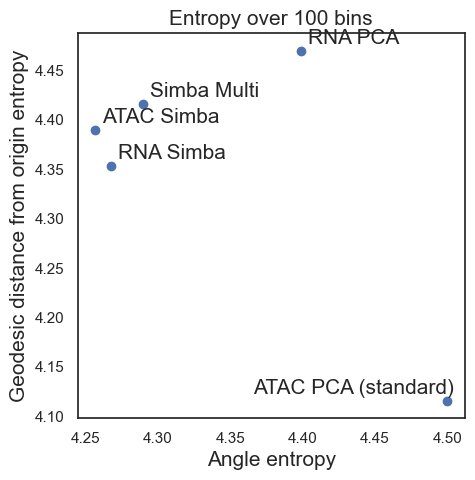

In [366]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(angle_entropy.loc[dist_from_origin_entropy.index], dist_from_origin_entropy)
for method in angle_entropy.index:
    x = angle_entropy.loc[method]
    y = dist_from_origin_entropy.loc[method]
    
    ha = 'left' if method != 'ATAC PCA (standard)' else 'right'
    print(method, ha)
    plt.annotate(
        method,
        (x, y),
        xytext=(5, 5),  # 5 points offset
        textcoords='offset points',
        fontsize=15,
        ha=ha # horizontal alignment
    )

plt.title("Entropy over 100 bins", fontsize=15)
plt.xlabel('Angle entropy', fontsize=15)
plt.ylabel('Geodesic distance from origin entropy', fontsize=15)
plt.show()

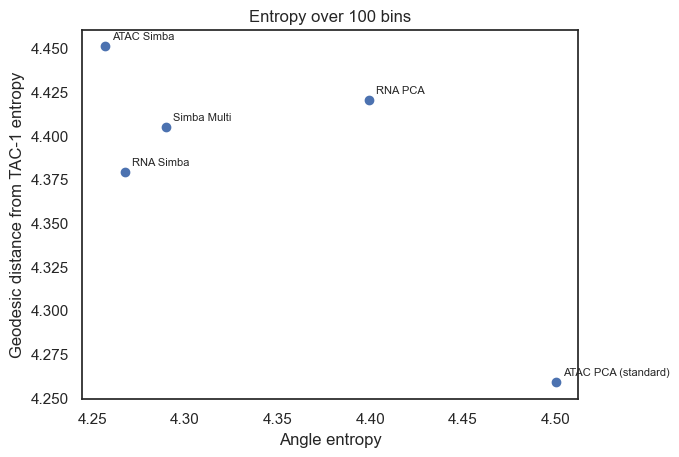

In [348]:
plt.scatter(angle_entropy.loc[dist_from_TAC1_entropy.index], dist_from_TAC1_entropy)
for method in angle_entropy.index:
    x = angle_entropy.loc[method]
    y = dist_from_TAC1_entropy.loc[method]
    plt.annotate(
        method,
        (x, y),
        xytext=(5, 5),  # 5 points offset
        textcoords='offset points',
        fontsize=8,
        ha='left'  # horizontal alignment
    )

plt.title("Entropy over 100 bins")
plt.xlabel('Angle entropy')
plt.ylabel('Geodesic distance from TAC-1 entropy')
plt.show()

In [351]:
dist_from_TAC1_entropy.loc[angle_entropy.index] / angle_entropy

name
ATAC PCA (standard)    0.946353
ATAC Simba             1.045586
RNA PCA                1.004728
RNA Simba              1.026104
Simba Multi            1.026750
dtype: float64